In [30]:
## ====================== Mount Google Drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [31]:
## ====================== Libraries:
""" For plotting """
import numpy as np
import matplotlib.pyplot as plt

""" For IPython """
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

""" For conversion """
from skimage.color import lab2rgb, rgb2lab, rgb2gray

""" For everything """
import torch
import torch.nn as nn
import torch.nn.functional as F

""" For our model """
import torchvision.models as models
from torchvision import datasets, transforms

""" For utilities """
import os, time

""" Check if GPU is available """
use_gpu = torch.cuda.is_available()

"""" new """
import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [44]:
train_paths[0]

'/content/gdrive/MyDrive/Data/DeepLearning2021/images/train/death cap/2828975396_f32cfd25e1.jpg'

In [45]:
## ====================== Load data:
# paths
train_path = '/content/gdrive/MyDrive/Data/DeepLearning2021/images/train'
val_path   = '/content/gdrive/MyDrive/Data/DeepLearning2021/images/val'
train_paths = glob.glob(train_path + "/**/*.jpg") # Grabbing all the image file names
val_paths   = glob.glob(val_path + "/**/*.jpg")   # Grabbing all the image file names

# def dataset
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
        self.labels = list(set([value.split('/')[2] for value in paths]))
        self.class_to_idx = {j:i for i, j in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        label = self.paths[idx].split("/")[2]
        idx = self.class_to_idx[label]
        # return {'L': L, 'ab': ab, "label": idx}
        img_original = L
        img_ab = ab
        target = idx
        return img_original, img_ab, target
    
    def __len__(self):
        return len(self.paths)

# def dataloader
def make_dataloaders(batch_size=16, n_workers=0, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, 
                            batch_size=batch_size, 
                            num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

# loaders 
train_loader = make_dataloaders(paths=train_paths, split='train')
val_loader = make_dataloaders(paths=val_paths, split='val')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


batche size: 16
number of Batches: 134
number of features: 3
features 01 shape: torch.Size([16, 1, 256, 256])
observations 01 shape: torch.Size([1, 256, 256])
image shape: torch.Size([256, 256])


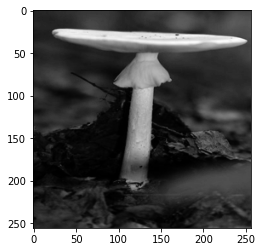

In [46]:
# check 
batche_size = 16
print(f"batche size: {batche_size}")
batches = iter(train_loader)
print(f"number of Batches: {len(batches)}")
batch = next(batches)
print(f"number of features: {len(batch)}")
feature_01 = batch[0] 
print(f"features 01 shape: {feature_01.size()}")
observation_01 = feature_01[0]
print(f"observations 01 shape: {observation_01.size()}")
img = observation_01.squeeze()
print(f"image shape: {img.size()}")
plt.imshow(img, cmap="gray")
plt.show()

In [47]:
## ====================== The Model:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    # First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    """ Change first conv layer to accept single-channel (grayscale) input """
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    """ Extract midlevel features from ResNet-gray """
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    # Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):
    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)
    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

model = ColorizationNet()

In [48]:
## ====================== Helper functions:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()

  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [50]:
## ====================== Set-up Training:
# Loss Function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

## ====================== Training:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [51]:
## ====================== Validation:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

In [52]:
## ====================== Main Driver:
# to GPU
if use_gpu: 
  criterion = criterion.cuda()
  model = model.cuda()

# Make folders and set parameters
import os
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = False
best_losses = 1e10
epochs = 100

# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/134]	Time 0.837 (0.837)	Data 0.494 (0.494)	Loss 0.1147 (0.1147)	
Epoch: [0][25/134]	Time 4.790 (4.325)	Data 4.763 (4.286)	Loss 0.0394 (0.0399)	
Epoch: [0][50/134]	Time 4.126 (4.271)	Data 4.098 (4.238)	Loss 0.0248 (0.0330)	
Epoch: [0][75/134]	Time 4.188 (4.301)	Data 4.161 (4.270)	Loss 0.0356 (0.0321)	
Epoch: [0][100/134]	Time 4.220 (4.303)	Data 4.193 (4.273)	Loss 0.0229 (0.0316)	
Epoch: [0][125/134]	Time 4.237 (4.313)	Data 4.210 (4.284)	Loss 0.0244 (0.0331)	
Finished training epoch 0
Validate: [0/34]	Time 4.070 (4.070)	Loss 0.0492 (0.0492)	
Validate: [25/34]	Time 4.192 (4.288)	Loss 0.1244 (0.1429)	
Finished validation.
Starting training epoch 1
Epoch: [1][0/134]	Time 0.527 (0.527)	Data 0.500 (0.500)	Loss 0.0143 (0.0143)	
Epoch: [1][25/134]	Time 0.510 (0.533)	Data 0.483 (0.506)	Loss 0.0192 (0.0197)	
Epoch: [1][50/134]	Time 0.545 (0.528)	Data 0.518 (0.502)	Loss 0.0209 (0.0236)	
Epoch: [1][75/134]	Time 0.502 (0.527)	Data 0.475 (0.500)	Loss 0.0399 (0.0

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3645 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2206 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 138 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 654 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: 

Validate: [0/34]	Time 0.897 (0.897)	Loss 0.0357 (0.0357)	
Validate: [25/34]	Time 0.522 (0.533)	Loss 0.0278 (0.0244)	
Finished validation.


<Figure size 432x288 with 0 Axes>

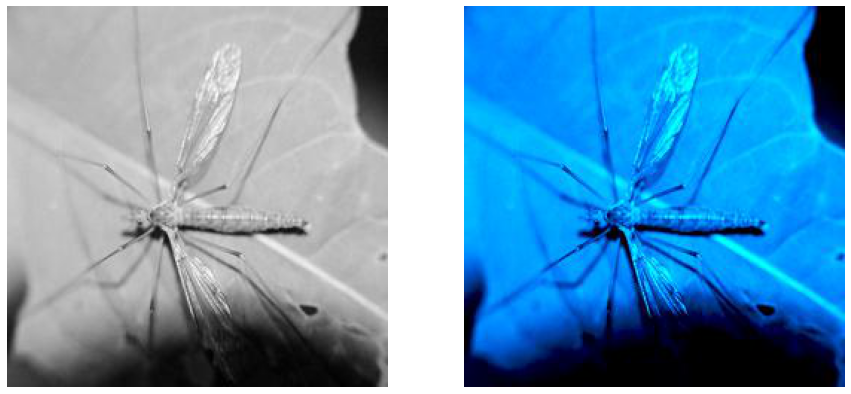

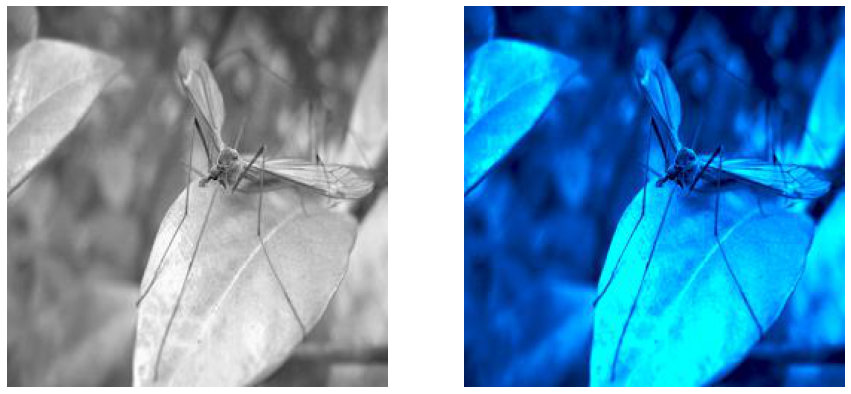

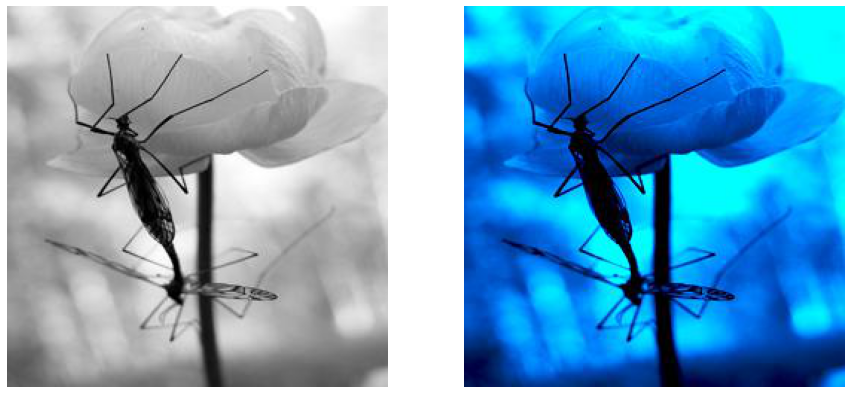

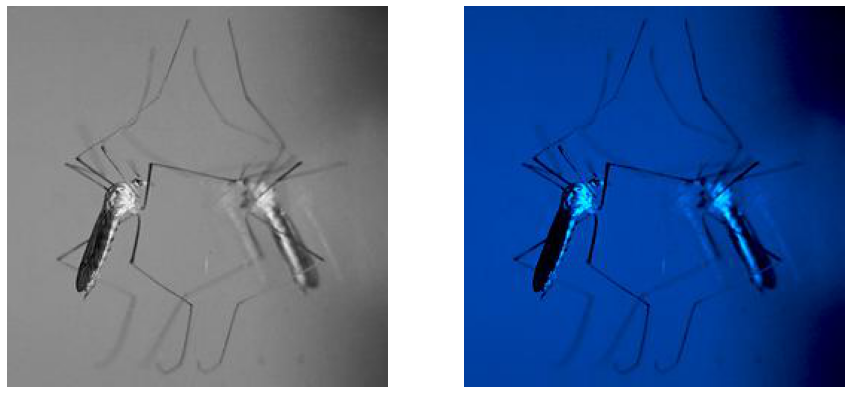

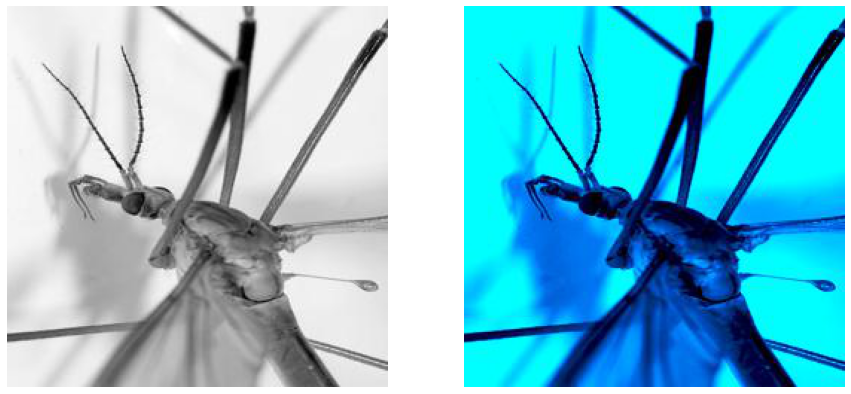

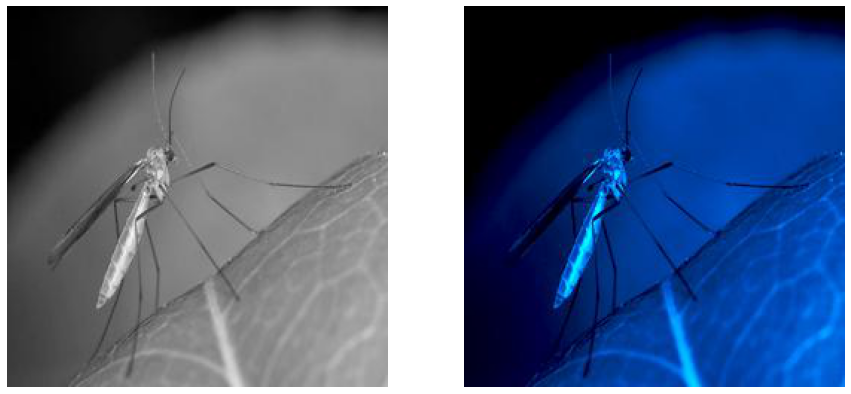

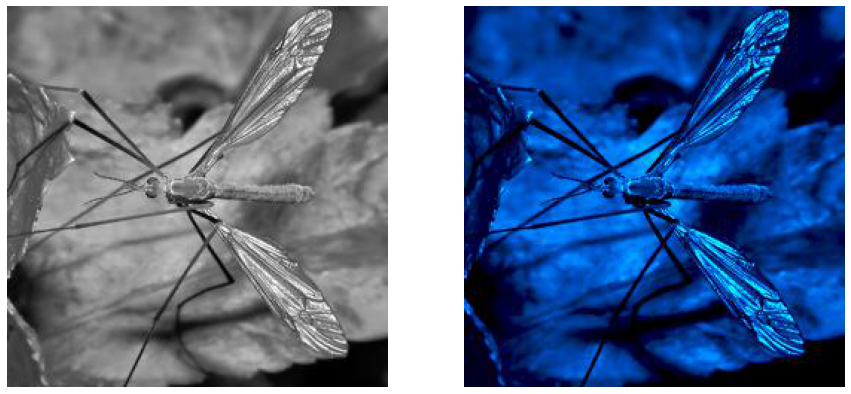

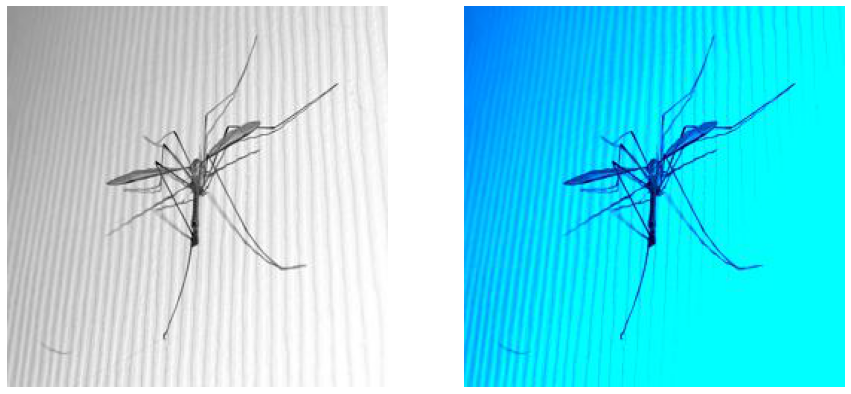

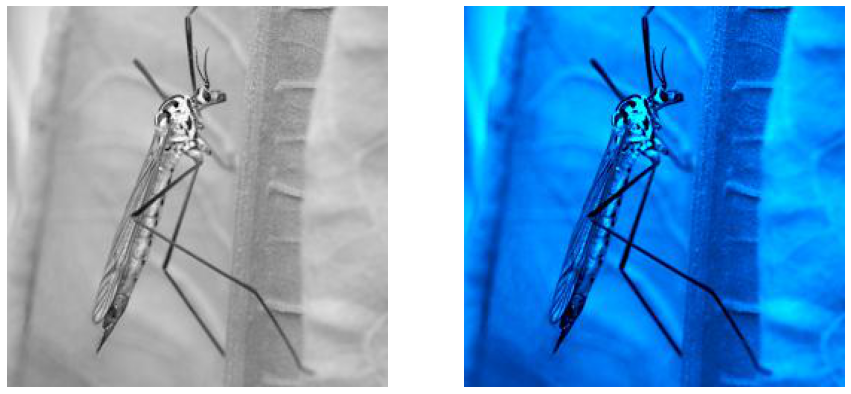

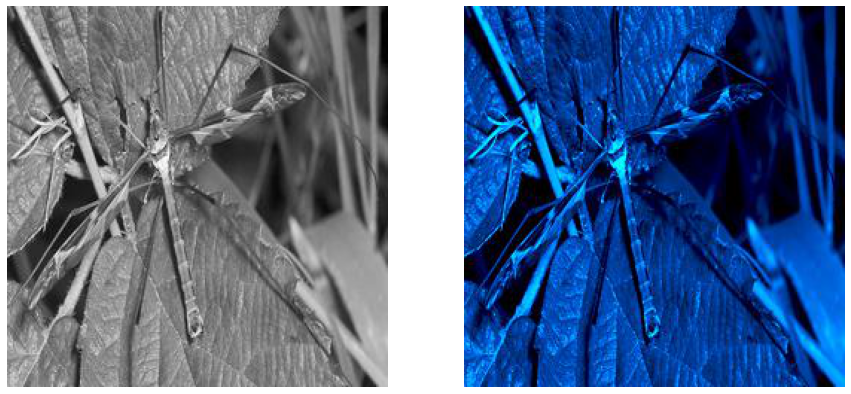

In [53]:
## ====================== Pretrained model:
# data = next(iter(train_loader))
# Ls     = data[0] 
# abs_   = data[1] 
# target = data[2]

# print(f"Feature batch shape: {Ls.size()}")
# print(f"Labels batch shape: {abs_.size()}")

# img = Ls[0].squeeze()
# plt.imshow(img, cmap="gray")
# plt.show()

# Load model
check_point = '/content/checkpoints/model-epoch-16-losses-0.025.pth'
pretrained = torch.load(check_point, map_location=lambda storage, loc: storage)
model.load_state_dict(pretrained)

# Make folders
import os
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)

# Validate
save_images = True
with torch.no_grad():
  validate(val_loader, model, criterion, save_images, 0)

# Show images 
import matplotlib.image as mpimg
image_pairs = [(f'outputs/color/img-{i}-epoch-0.jpg', 
                f'outputs/gray/img-{i}-epoch-0.jpg')
                 for i in range(0,10)]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()